In [19]:
import sys
sys.path.append('splinedistm')

import matplotlib.pyplot as plt
import numpy as np
import cv2

from csbdeep.utils import normalize
from glob import glob
from skimage import io
from splinedist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from splinedist.models import Config2D, SplineDist2D, SplineDistData2D
from splinedist.utils import phi_generator, grid_generator, get_contoursize_max
from tqdm import tqdm

In [20]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [21]:
def train_validation_split(X, Y, percent_test = 0.25):
  rng = np.random.default_rng(591)
  indices = rng.permutation(len(X))
  split_val = max(1, int(round(percent_test * len(indices))))
  train_indices, valid_indices = indices[split_val:], indices[:split_val]
  X_train, X_valid = [X[i] for i in train_indices], [X[i] for i in valid_indices]
  Y_train, Y_valid = [Y[i] for i in train_indices], [Y[i] for i in valid_indices]

  print(f'Number of images: {len(X)}')
  print(f'- training: {len(train_indices)}')
  print(f'- validation: {len(valid_indices)}')
  return X_train, Y_train, X_valid, Y_valid

# Load Images and Masks

In [22]:
image_dir = f'images'
hela_dir = f'{image_dir}/fluo-ND2L-HeLa'
merfish_dir = f'{image_dir}/merfish'

model_dir = 'models'

In [23]:
# Read train images that manually segmentated and fill small label holes
merfish_X_train_names = sorted(glob(f'{merfish_dir}/train/images/*.tif'))
merfish_X_train = [normalize(img, 1, 99.8, axis=(0, 1)) for img in list(map(io.imread, merfish_X_train_names))]
merfish_Y_train_names = sorted(glob(f'{merfish_dir}/train/masks/manual/*.tif'))
merfish_Y_train = [fill_label_holes(img) for img in tqdm(list(map(io.imread, merfish_Y_train_names)))]

100%|██████████| 34/34 [00:01<00:00, 25.42it/s]


In [24]:
assert(len(merfish_X_train) == len(merfish_Y_train))

In [25]:
# Train validation split
merfish_X_train, merfish_Y_train, merfish_X_valid, merfish_Y_valid = train_validation_split(merfish_X_train, merfish_Y_train, 0.1)

Number of images: 34
- training: 31
- validation: 3


In [26]:
# Read test images and masks, normalize test images
merfish_X_test_names = sorted(glob(f'{merfish_dir}/test/images/*.tif'))
merfish_X_test = [normalize(img, 1, 99.8, axis=(0, 1)) for img in list(map(io.imread, merfish_X_test_names))]
merfish_Y_test_names = sorted(glob(f'{merfish_dir}/test/masks/*.tif'))
merfish_Y_test = list(map(io.imread, merfish_Y_test_names))

In [27]:
assert(len(merfish_X_test) == len(merfish_Y_test))

# Preprocessing

In [28]:
# Apply median filter with r = 2 for all images
merfish_X_train = [cv2.medianBlur(img, 5) for img in tqdm(merfish_X_train)]
merfish_X_test = [cv2.medianBlur(img, 5) for img in tqdm(merfish_X_test)]

100%|██████████| 8/8 [00:00<00:00, 18.55it/s]


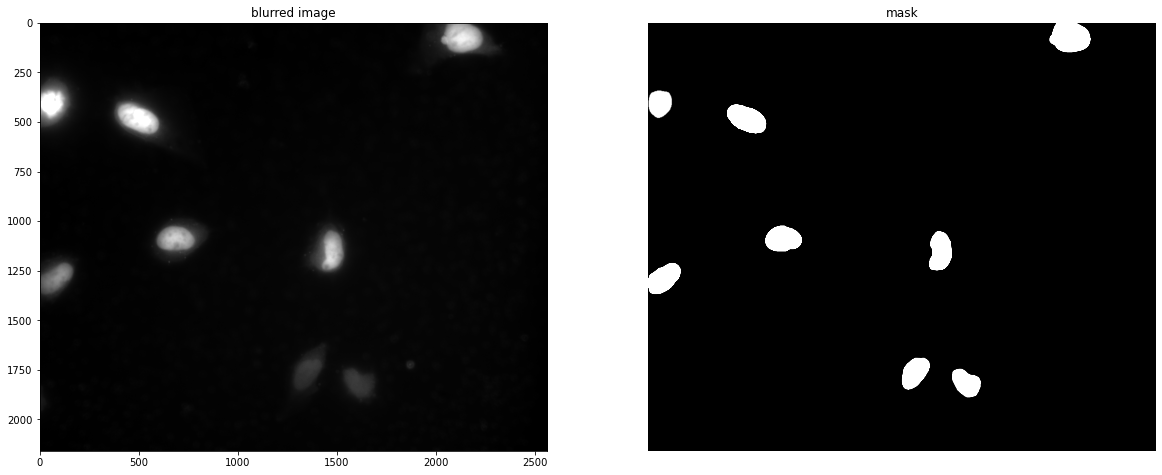

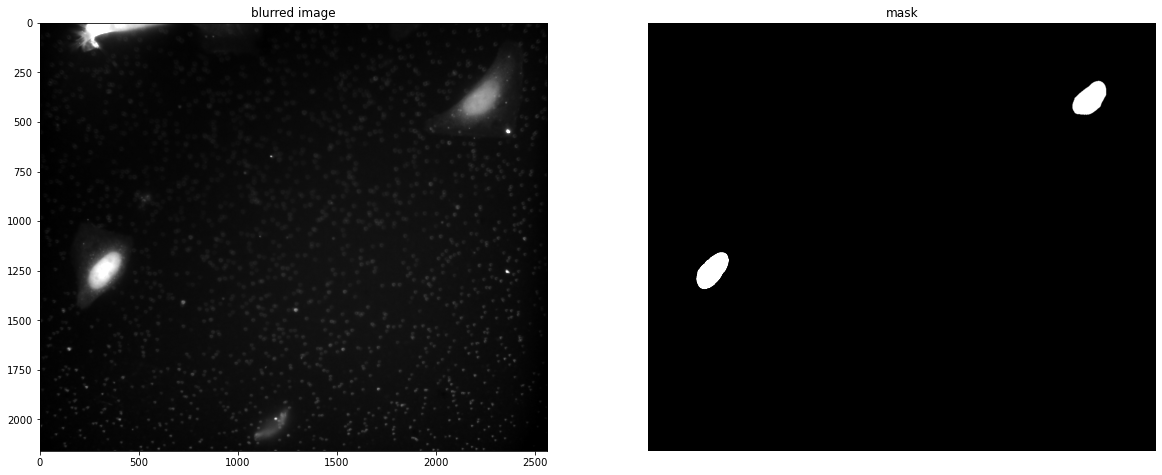

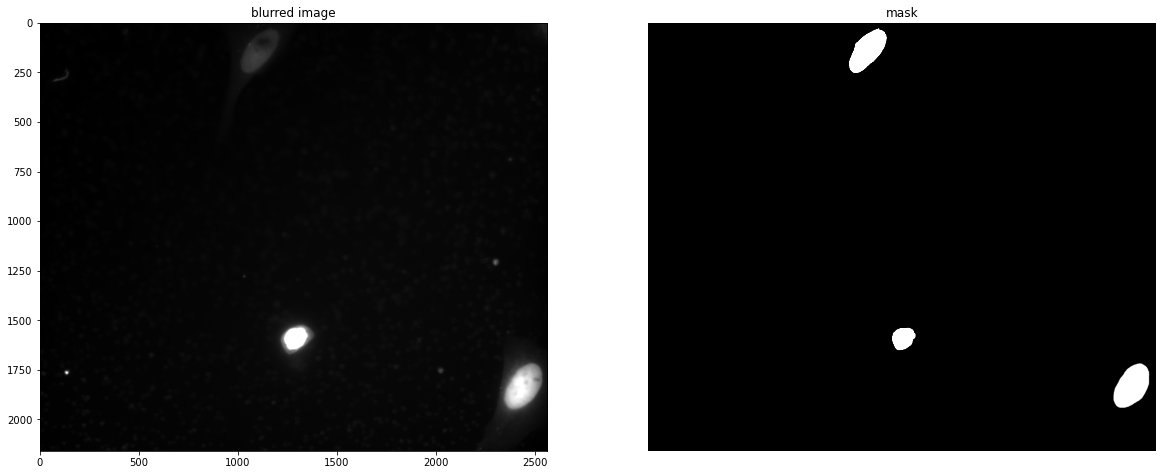

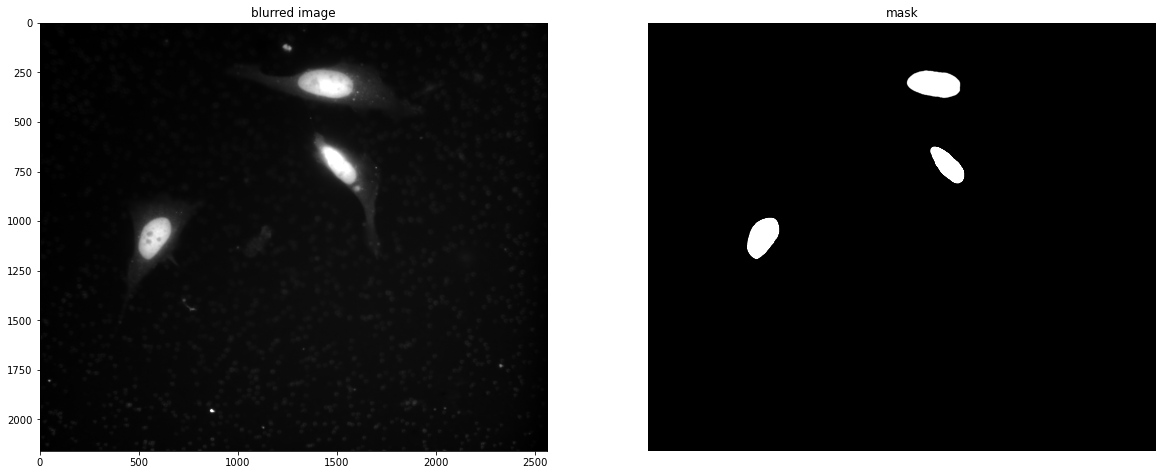

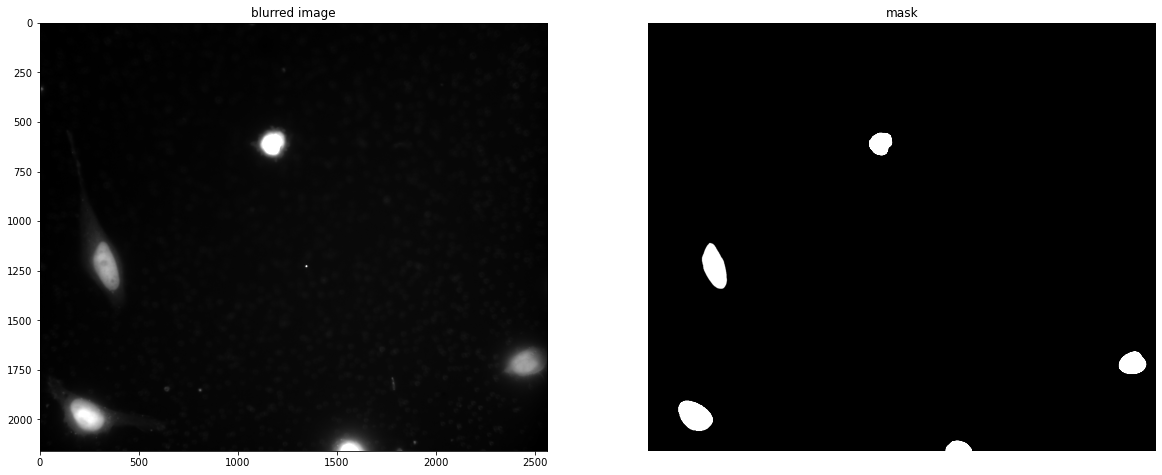

In [29]:
# Show some manually segmented images and masks with blur
for i in range(5):
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))
  axes[0].imshow(merfish_X_train[i], clim=(0,1), cmap='gray')
  axes[0].set_title('blurred image')
  axes[1].imshow(merfish_Y_train[i], clim=(0,1), cmap='gray')
  axes[1].set_title('mask')
  axes[1].axis('off')

# Train Splinedist Model on MERFISH data using manually-segmented ground truth

In [34]:
# choose the number of control points (M)
M = 6
n_params = 2 * M

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (4,4)

# compute the size of the largest contour present in the image-set
contoursize_max = get_contoursize_max(merfish_Y_train)

conf = Config2D (
    n_params        = n_params,
    grid            = grid,
    n_channel_in    = 1,
    contoursize_max = contoursize_max,
    train_patch_size = (512,512),
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', contoursize_max=706, grid=(4, 4), n_channel_in=1, n_channel_out=13, n_dim=2, n_params=12, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(512, 512), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 13,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_params': 12,
 'grid': (4, 4),
 'backbone': 'unet',
 'contoursize_max': 706,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (512, 512),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,
 'train_batch_size': 4,
 'train_n_val_patches': None,


In [35]:
phi_generator(M, conf.contoursize_max)
grid_generator(M, conf.train_patch_size, conf.grid)

In [36]:
splinedist_merfish_model = SplineDist2D(conf, name='splinedist_merfish', basedir=model_dir) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [37]:
splinedist_merfish_model.train(merfish_X_train, merfish_Y_train, validation_data=(merfish_X_valid, merfish_Y_valid), augmenter=None, epochs=300)

ValueError: too many values to unpack (expected 2)